In [2]:
library(lme4)
options(rgl.useNULL=TRUE)
library(LMERConvenienceFunctions)

library(ggplot2)
options(jupyter.plot_mimetypes = 'image/png')
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

library(car)
library(MASS)

library(vcd)

Loading required package: Matrix
Loading required package: grid


# Number of answers

In this notebook, we document our various steps taken to study the effect of the course of a session on the readability of a comment. Note that we only do this on a sample of 1 mio. data points here.

In [3]:
data = read.csv("/home/psinger/Reddit-depletion/data/sample.csv", header=TRUE)

In [4]:
nrow(data)

[1] 1000000

## Data inspection

We start by getting a better feeling of our data. 

We can limit our data to those sessions that have at least two comments.

In [5]:
idx = data$session_comments>1

In [6]:
data = data[idx,]

In [7]:
nrow(data)

[1] 669019

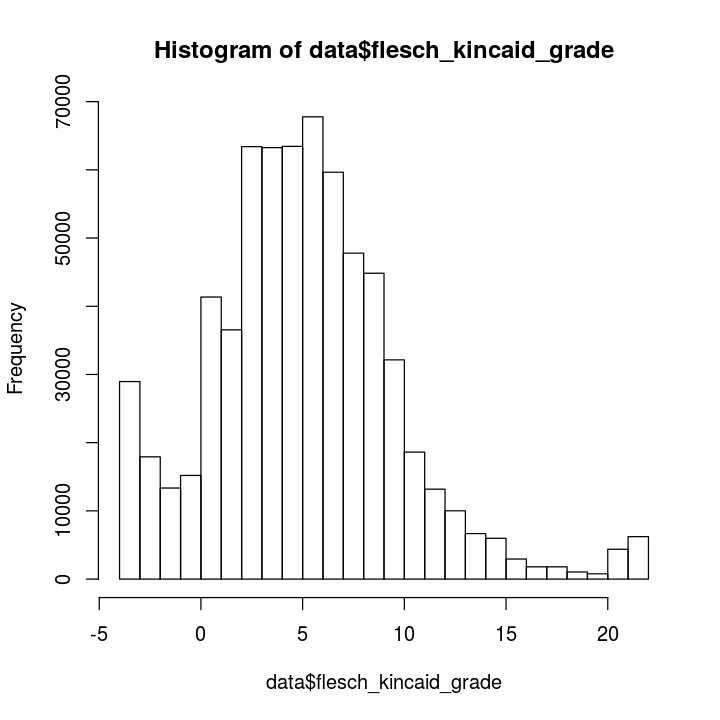

In [8]:
hist(data$flesch_kincaid_grade)

## Regression model

We use mixed-effects models where in the basic form (that we analyze in this notebook), we are interested in studying flesch_kincaid_grade ~ 1 + session_index + session_comments + (1|author).

### Linear mixed-effects regression

We start with a linear mixed-effects model.

In [9]:
m_lmer = lmer(flesch_kincaid_grade~1+session_index + session_comments+(1|author), data=data, REML=FALSE)

In [10]:
summary(m_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_index + session_comments +  
    (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3922755  3922812 -1961373  3922745   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6404 -0.5823 -0.0435  0.5142  5.2008 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.491   1.578   
 Residual             18.519   4.303   
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       5.1600085  0.0069014   747.7
session_index    -0.0035398  0.0007249    -4.9
session_comments -0.0042379  0.0004799    -8.8

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.046       
sssn_cmmnts -0.188 -0.767

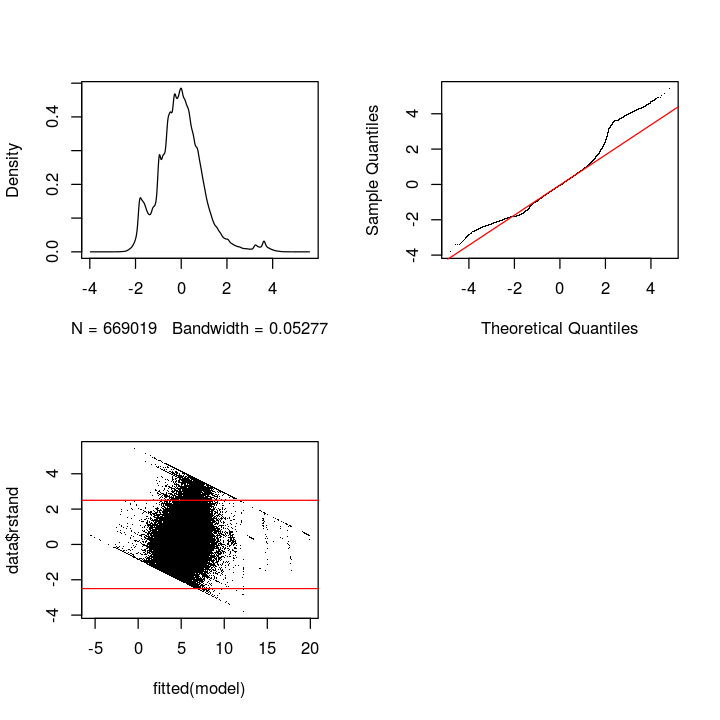

In [34]:
mcp.fnc(m_lmer)

While not perfect, the residuals do not look to bad for large data here. The deviations from normality might be explained by the peaks in data at both ends of the distribution (large and low readability). Let us quickly try two transformations on the outcome (sqrt and log) for which we first set the outcome positive by adding a constant.

In [35]:
min(data$flesch_kincaid_grade)
data$flesch_kincaid_grade.t = data$flesch_kincaid_grade + 4.4

[1] -3.4

### Linear mixed-effects regression (transform)

In [36]:
m_lmer_log = lmer(log(flesch_kincaid_grade.t)~1+session_index+session_comments+(1|author), data=data, REML=FALSE)

In [37]:
summary(m_lmer_log)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(flesch_kincaid_grade.t) ~ 1 + session_index + session_comments +  
    (1 | author)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
1279385.9 1279442.9 -639687.9 1279375.9    669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3578 -0.2986  0.1905  0.5765  3.7325 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.04635  0.2153  
 Residual             0.35733  0.5978  
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       2.106e+00  9.545e-04  2206.7
session_index    -5.273e-04  1.007e-04    -5.2
session_comments -7.613e-04  6.656e-05   -11.4

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.046       
sssn_cmmnts -0.189 -0.768

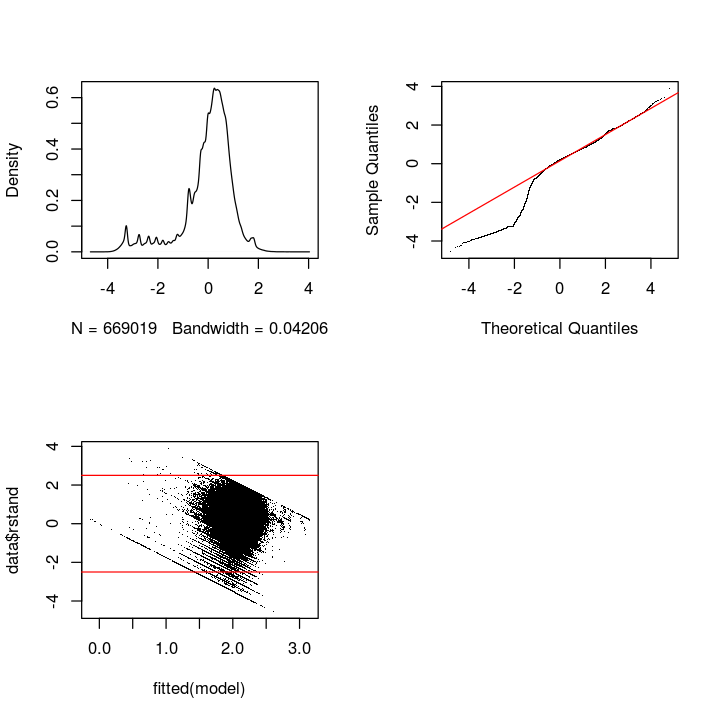

In [38]:
mcp.fnc(m_lmer_log)

In [39]:
m_lmer_sqrt = lmer(sqrt(flesch_kincaid_grade.t)~1+session_index+session_comments+(1|author), data=data, REML=FALSE)
summary(m_lmer_sqrt)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: sqrt(flesch_kincaid_grade.t) ~ 1 + session_index + session_comments +  
    (1 | author)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
1564647.2 1564704.3 -782318.6 1564637.2    669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9423 -0.4769  0.0787  0.5793  4.4671 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.07518  0.2742  
 Residual             0.54428  0.7378  
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       2.992e+00  1.187e-03  2520.5
session_index    -6.515e-04  1.243e-04    -5.2
session_comments -8.489e-04  8.236e-05   -10.3

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.046       
sssn_cmmnts -0.188 -0.766

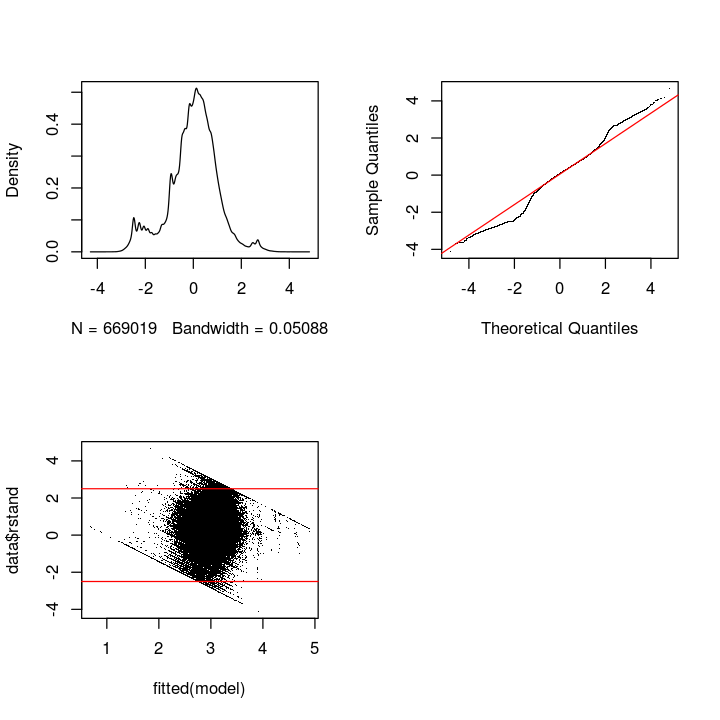

In [40]:
mcp.fnc(m_lmer_sqrt)

Looks quite similar to the non-transformed.

Let us focus on a potentially more appropriate Gamma generalized linear mixed-effects model next though.

### Gamma GLMER

Let us model the data with a Gamma GLMER using a log link.

In [41]:
m_gamma = glmer(flesch_kincaid_grade.t~1+session_index+session_comments+(1|author),data=data,family=Gamma(link=log))
summary(m_gamma)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00712948 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: flesch_kincaid_grade.t ~ 1 + session_index + session_comments +  
    (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3919737  3919794 -1959864  3919727   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0698 -0.5209  0.0376  0.5709  9.5108 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.04613  0.2148  
 Residual             0.20702  0.4550  
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value Pr(>|z|)    
(Intercept)       2.201e+00  1.044e-03  2107.1  < 2e-16 ***
session_index    -4.401e-04  8.455e-05    -5.2 1.94e-07 ***
session_comments -2.838e-04  5.843e-05    -4.9 1.19e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.03

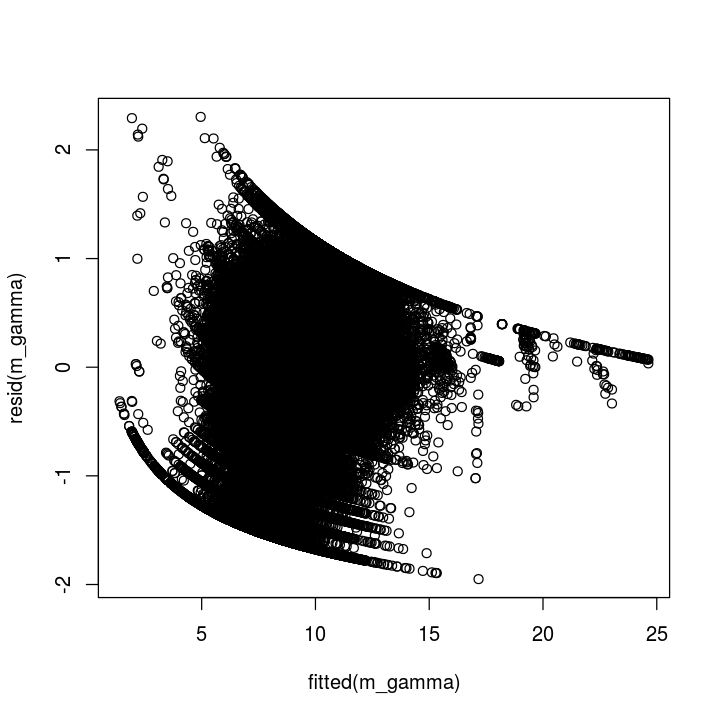

In [42]:
plot(fitted(m_gamma),resid(m_gamma))

The convergence message shows low magnitude and for such large data this might be a false positive as emphasized in the lme4 docu. 

The coefficients are quite similar to our previous analyses.

## Final model choice

Given our extensive analysis regarding the appropriate model for our data, we can conclude that all have very similar conclusions, namely that the session_index has a negative effect on the Flesch-Kincaid grade meaning that readability complexity decreases. Nonetheless, we will proceed with a linear model on the flesch_kincaid_grade due to the reasonable diagnostic plots and the simplicity of the model. We thus take slight deviations from normality of the residuals into account, the residuals do not indicate too much heteroskedasticity.

## Significance of effects

Now that we have decided on a model, we want to extend our inference. First, we want to study the significance of the fixed effects as well as potential additional random effects. 

There are several options for determining the significance of a fixed effect on the model. For example, a common approach is to use the ratio of the slope to its standard error and then use a t-test for determining its significance. Alternatively, one can also use F-tests for contrasting simpler to more complex models. Both methods require a specification of the degrees of freedom though which is not trivial in mixed models; methods such as the Satterthwaite approximation or Kenward-Roger approximation can be used for that task. 
As stated in Baayen 2008, we can also directly use the t-statistics given to derive statistical significance. Because we have a huge dataset, a t-statistic above 2 can be regarded as significant at the 5\% level in a two-tailed test. You can derive this directly from the results above.

However, here, we follow an approach used for comparing models: the Bayesian Information Criterion (alternatively we could also work with AIC or LRT). Basically, the idea is to specify different (in this case nested) models that successively incorporate additional fixed or random effects and then compare their BIC scores. The lower the BIC, the better a model is (above a small threshold).

The baseline model we start with is:

flesch_kincaid_grade = 1 + (1|author)

The reason why we incorporate the random effect for author from the beginning is that this is necessary based on the design of the experiment. Also, as pointed out in http://glmm.wikidot.com/faq, you should not compare the fit of a (g)lmer with one from a (g)lm.

Okay, so let us get the BIC for the baseline model.

In [43]:
m1 = lmer(flesch_kincaid_grade~1+(1|author), data = data, REML=FALSE)
summary(m1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3923158  3923192 -1961576  3923152   669016 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5842 -0.5790 -0.0427  0.5139  4.8527 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.533   1.592   
 Residual             18.501   4.301   
Number of obs: 669019, groups:  author, 304104

Fixed effects:
            Estimate Std. Error t value
(Intercept) 5.111339   0.006474   789.6

Next, let us incorporate the index and session length individually.

In [44]:
m2 = lmer(flesch_kincaid_grade~1+session_index+(1|author), data = data, REML=FALSE)
summary(m2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_index + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3922831  3922877 -1961412  3922823   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6183 -0.5821 -0.0434  0.5141  4.9674 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.502   1.582   
 Residual             18.514   4.303   
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                Estimate Std. Error t value
(Intercept)    5.1485062  0.0067810   759.3
session_index -0.0084429  0.0004651   -18.2

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.302

In [45]:
m3 = lmer(flesch_kincaid_grade~1+session_comments+(1|author), data = data, REML=FALSE)
summary(m3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3922777  3922823 -1961385  3922769   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6435 -0.5826 -0.0435  0.5142  5.2609 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.491   1.578   
 Residual             18.520   4.304   
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       5.1584515  0.0068940   748.3
session_comments -0.0060357  0.0003079   -19.6

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.349

Based on the lower BIC we can clearly see that the incorporation of the session_index and session_comments (separately) improve our model, thus, we make inference on it (also the t-value indicates high significance).

In [46]:
m4 = lmer(flesch_kincaid_grade~1+session_index+session_comments+(1|author), data = data, REML=FALSE)
summary(m4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_index + session_comments +  
    (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3922755  3922812 -1961373  3922745   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6404 -0.5823 -0.0435  0.5142  5.2008 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.491   1.578   
 Residual             18.519   4.303   
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       5.1600085  0.0069014   747.7
session_index    -0.0035398  0.0007249    -4.9
session_comments -0.0042379  0.0004799    -8.8

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.046       
sssn_cmmnts -0.188 -0.767

As expected based on our initial empirical analysis in the paper, both the session index and session length are important effect to incorporate.

We stop at this point as our scope of interest is covered. However, one can arbitrarily extend the existing model.
For example, one might also argue that it is necessary to incorporate a random effect for the intercept based on different subreddits.

In [47]:
m5 = lmer(flesch_kincaid_grade~1+session_index+session_comments+(1|author)+(1|subreddit), data = data, REML=FALSE)
summary(m5)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_index + session_comments +  
    (1 | author) + (1 | subreddit)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3900236  3900304 -1950112  3900224   669013 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4012 -0.5930 -0.0475  0.5122  5.0701 

Random effects:
 Groups    Name        Variance Std.Dev.
 author    (Intercept)  1.613   1.270   
 subreddit (Intercept)  1.709   1.307   
 Residual              18.283   4.276   
Number of obs: 669019, groups:  author, 304104; subreddit, 12583

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       5.0910871  0.0207664  245.16
session_index    -0.0036359  0.0007188   -5.06
session_comments -0.0010242  0.0004755   -2.15

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.015       
sssn_cmmnts -0.046 -0.770

Again, the BIC shows an improvement in the model. Yet, the inference on the fixed effects does not change. For complexity reasons, we neglect the random effect for the subreddit for the complete data.

### Collinearity

We also want to check for multicollinearity in our model; some explanations and code for checking that in lme4 is provided in https://hlplab.wordpress.com/2011/02/24/diagnosing-collinearity-in-lme4/.

In [48]:
source("mer-utils.R")
kappa.mer(m4)
max(vif.mer(m4))

[1] 4.566001

[1] 2.429685

Both the condition number and VIF show no reasons to be concerned about collinearity in this model.

### Length as random effect

We have decided to incorporate the variation between different session lengths as a controlling covariate, however we might also incorporate it as a controlling random effect.

In [57]:
m4_control = lmer(flesch_kincaid_grade~1+session_index+(1|session_comments)+(1|author), data = data, REML=FALSE)
summary(m4_control)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_index + (1 | session_comments) +  
    (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3922696  3922753 -1961343  3922686   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6077 -0.5840 -0.0438  0.5147  4.8887 

Random effects:
 Groups           Name        Variance Std.Dev.
 author           (Intercept)  2.48105 1.5751  
 session_comments (Intercept)  0.04195 0.2048  
 Residual                     18.52056 4.3036  
Number of obs: 669019, groups:  author, 304104; session_comments, 328

Fixed effects:
                Estimate Std. Error t value
(Intercept)    4.8655352  0.0302166  161.02
session_index -0.0051263  0.0005311   -9.65

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.451

The results are similar.

## Randomized baseline data

In order to finally confirm our intuition and inference on the negative effect of the session index on the number of responses, we also study our randomized baseline data. We basically have two different randomized datasets: (i) new sessions based on randomized time differences and (ii) randomized positions inside existing sessions.

In [50]:
idx = data$session_comments_random > 1
data_random = data[idx,]

In [51]:
m1_random = lmer(flesch_kincaid_grade~1+(1|author), data = data_random, REML=FALSE)
summary(m1_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 3126376  3126410 -1563185  3126370   533135 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5825 -0.5796 -0.0442  0.5139  4.8501 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.545   1.595   
 Residual             18.525   4.304   
Number of obs: 533138, groups:  author, 232025

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.10119    0.00734   694.9

In [52]:
m2_random = lmer(flesch_kincaid_grade~1+session_index_random+(1|author), data = data_random, REML=FALSE)
summary(m2_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_index_random + (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 3126361  3126406 -1563177  3126353   533134 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5861 -0.5792 -0.0440  0.5140  4.8684 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.541   1.594   
 Residual             18.527   4.304   
Number of obs: 533138, groups:  author, 232025

Fixed effects:
                       Estimate Std. Error t value
(Intercept)           5.1115822  0.0077612   658.6
session_index_random -0.0029520  0.0007169    -4.1

Correlation of Fixed Effects:
            (Intr)
sssn_ndx_rn -0.325

In [53]:
m3_random = lmer(flesch_kincaid_grade~1+session_comments_random+(1|author), data = data_random, REML=FALSE)
summary(m3_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_comments_random + (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 3126342  3126387 -1563167  3126334   533134 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5879 -0.5793 -0.0438  0.5144  4.8259 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.537   1.593   
 Residual             18.529   4.304   
Number of obs: 533138, groups:  author, 232025

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              5.1192561  0.0079303   645.5
session_comments_random -0.0029898  0.0004974    -6.0

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnt_ -0.379

In [54]:
m4_random = lmer(flesch_kincaid_grade~1+session_index_random+session_comments_random+(1|author), data = data_random, REML=FALSE)
summary(m4_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
flesch_kincaid_grade ~ 1 + session_index_random + session_comments_random +  
    (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 3126343  3126399 -1563167  3126333   533133 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5876 -0.5792 -0.0438  0.5144  4.8158 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.537   1.593   
 Residual             18.529   4.305   
Number of obs: 533138, groups:  author, 232025

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              5.1189954  0.0079362   645.0
session_index_random     0.0009587  0.0011335     0.8
session_comments_random -0.0035051  0.0007865    -4.5

Correlation of Fixed Effects:
            (Intr) sssn_n_
sssn_ndx_rn -0.039        
sssn_cmmnt_ -0.210 -0.775 

When comparing m3_random and m4_random, we can see now is that the incorporation of the session index is not improving the model in terms of the BIC score  and is thus, not significant (also has a low t-value < 2). 

The reason why the session length itself is still significant can be explained by our very conservative randomization method that just randomizes the time differences between comments before sessionizing and thus, still keeps many sessions intact.

### Randomized indexes

In [58]:
m3_random_2 = lmer(flesch_kincaid_grade~1+session_comments+(1|author), data = data, REML=FALSE)
summary(m3_random_2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3922777  3922823 -1961385  3922769   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6435 -0.5826 -0.0435  0.5142  5.2609 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.491   1.578   
 Residual             18.520   4.304   
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       5.1584515  0.0068940   748.3
session_comments -0.0060357  0.0003079   -19.6

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.349

In [59]:
m4_random_2 = lmer(flesch_kincaid_grade~1+session_index_random_2+session_comments+(1|author), data = data, REML=FALSE)
summary(m4_random_2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
flesch_kincaid_grade ~ 1 + session_index_random_2 + session_comments +  
    (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 3922776  3922833 -1961383  3922766   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6431 -0.5826 -0.0436  0.5143  5.1296 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.491   1.578   
 Residual             18.520   4.304   
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                         Estimate Std. Error t value
(Intercept)             5.1578483  0.0069021   747.3
session_index_random_2  0.0012936  0.0007193     1.8
session_comments       -0.0066874  0.0004755   -14.1

Correlation of Fixed Effects:
            (Intr) ss___2
sssn_ndx__2 -0.049       
sssn_cmmnts -0.189 -0.762

Again, we see similar behavior, the incorporation of the random session index does not improve the model compared to one that already includes the session length.

Overall, the analyses presented in this notebook have demonstrated that the course of a session has a (negative) effect on the Flesch-Kincaid grade a comment received.